In [1]:
%%bash
nrnivmodl

/usr/bin/xcrun
/Users/anatolii-sorokin/Documents/Projects/neuro-trafic
Mod files: "./h.mod" "./kadist.mod" "./kaprox.mod" "./kdrca1.mod" "./km.mod" "./na3n.mod" "./naxn.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.dylib
Successfully created arm64/special


In [2]:
# Download NEURON: http://www.neuron.yale.edu/neuron/download
# Download PyNeuronToolbox: https://github.com/ahwillia/PyNeuron-Toolbox

from neuron import h
import numpy as np
import math
import pylab as plt
import scipy.linalg
from PyNeuronToolbox.record import ez_record,ez_convert
from PyNeuronToolbox.morphology import shapeplot,shapeplot_animate
from mpl_toolkits.mplot3d import Axes3D
from JSAnimation import IPython_display
from matplotlib import animation
from matplotlib.pyplot import cm
%matplotlib inline
np.random.seed(123456789)

DC = 10 # diffusion coeff [microns^2 s^-1]

# Load morphology and other stuff
# --> SegLists: soma[2], dend[74], dend_5[37], apic[42], axon[1]
# --> Files from Migliore & Migliore (2012)
# --> CA1 pyramidal neuron
h.load_file('stdrun.hoc')
h.xopen('ri06.hoc')
h.xopen('fixnseg.hoc')
h.xopen('5a_nogui.hoc')
h.tstop = 700.0

	0 
total # of segments (50Hz): 742   max path distance: 853.32493 
apical 0  dend_5[0]
apical 1  dend_5[15]
apical 2  dend_5[14]
apical 3  dend_5[13]
apical 4  dend_5[12]
apical 5  dend_5[12]
apical 6  dend_5[12]
apical 7  dend_5[12]
apical 8  dend_5[12]
apical 9  dend_5[12]
apical 10  dend_5[12]
apical 11  dend_5[11]
apical 12  dend_5[11]
apical 13  dend_5[11]
apical 14  dend_5[10]
apical 15  dend_5[9]
apical 16  dend_5[8]
apical 17  dend_5[8]
apical 18  dend_5[8]
apical 19  dend_5[7]
apical 20  dend_5[6]
apical 21  dend_5[5]
apical 22  dend_5[5]
apical 23  dend_5[5]
apical 24  dend_5[5]
apical 25  dend_5[5]
apical 26  dend_5[5]
apical 27  dend_5[5]
apical 28  dend_5[4]
apical 29  dend_5[4]
apical 30  dend_5[4]
apical 31  dend_5[3]
apical 32  dend_5[2]
apical 33  dend_5[2]
apical 34  dend_5[2]
apical 35  dend_5[2]
apical 36  dend_5[2]
apical 37  dend_5[2]
apical 38  dend_5[2]
apical 39  dend_5[1]
apical 40  dend_5[1]
apical 41  dend_5[1]
#1


In [3]:
from PyNeuronToolbox.morphology import dist_between,allsec_preorder

def dist_to_soma(segment):
    return dist_between(h,h.soma[0](0.5),segment)

#seglist in pre-order
sec_list = allsec_preorder(h)
seg_list = []
for sec in sec_list:
    locs = np.linspace(0,1,sec.nseg+2)[1:-1]
    for loc in locs:
        seg_list.append(sec(loc))
N = len(seg_list)
n = N

In [4]:
for i in range(len(sec_list)):
    sec = sec_list[i]
    print(f"{i}: {sec.name()}, nseg={sec.nseg}, L={sec.L}, or={sec.orientation()}, hname={sec.hname()}")

0: soma[0], nseg=1, L=15.166100084781647, or=0.0, hname=soma[0]
1: soma[1], nseg=1, L=10.883900105953217, or=0.0, hname=soma[1]
2: dend_5[0], nseg=1, L=27.29313676464808, or=0.0, hname=dend_5[0]
3: apic[0], nseg=9, L=147.93433051396065, or=0.0, hname=apic[0]
4: dend_5[1], nseg=3, L=57.45149110486393, or=0.0, hname=dend_5[1]
5: apic[39], nseg=1, L=23.29171407802628, or=0.0, hname=apic[39]
6: apic[41], nseg=3, L=34.922839435595144, or=0.0, hname=apic[41]
7: apic[40], nseg=5, L=52.39168693889804, or=0.0, hname=apic[40]
8: dend_5[2], nseg=1, L=21.183727600433784, or=0.0, hname=dend_5[2]
9: apic[32], nseg=1, L=12.617619533060896, or=0.0, hname=apic[32]
10: apic[38], nseg=13, L=208.40219120020532, or=0.0, hname=apic[38]
11: apic[33], nseg=1, L=9.679981164937955, or=0.0, hname=apic[33]
12: apic[37], nseg=3, L=32.69642802210867, or=0.0, hname=apic[37]
13: apic[34], nseg=1, L=6.683028121429655, or=0.0, hname=apic[34]
14: apic[36], nseg=5, L=58.600785345533666, or=0.0, hname=apic[36]
15: apic[35

In [5]:
s=h.soma[0]
print(f"{i}: {s.name()}, nseg={s.nseg}, L={s.L}, or={s.orientation()}, hname={s.hname()}")
s=h.soma[1]
print(f"{i}: {s.name()}, nseg={s.nseg}, L={s.L}, or={s.orientation()}, hname={s.hname()}")

155: soma[0], nseg=1, L=15.166100084781647, or=0.0, hname=soma[0]
155: soma[1], nseg=1, L=10.883900105953217, or=0.0, hname=soma[1]


In [6]:
i = 0
section = None
parentStack = [(None,h.soma[0])]
while len(parentStack)>0:
    (p,section) = parentStack.pop()
    print(f"i={i},p={p},section={section},len(parentStack)={len(parentStack)}")
    if p is not None:
        print(f'p is not None: {i},{p}')
    else:
        print(f'p is None: {i},{p}')
    for (j,seg) in enumerate(section):
        print(i,j,seg)
        if j>0:
            print(f"j>0, update A:j={j}, i={i}")
        i += 1
    print(f'Enumerated: i={i}')
    child_list = list(h.SectionRef(sec=section).child)
    if child_list is not None:
        print("child_list is not None")
        child_list.reverse()
    else:
        print("child_list is None")
    for c_sec in child_list:
        parentStack.append([i-1,c_sec]) # append parent index and child
    print(f"len(parentStack)={len(parentStack)}")
    print(parentStack)

i=0,p=None,section=soma[0],len(parentStack)=0
p is None: 0,None
0 0 soma[0](0.5)
Enumerated: i=1
child_list is not None
len(parentStack)=2
[[0, axon[0]], [0, soma[1]]]
i=1,p=0,section=soma[1],len(parentStack)=1
p is not None: 1,0
1 0 soma[1](0.5)
Enumerated: i=2
child_list is not None
len(parentStack)=6
[[0, axon[0]], [1, dend[0]], [1, dend[15]], [1, dend[28]], [1, dend[59]], [1, dend_5[0]]]
i=2,p=1,section=dend_5[0],len(parentStack)=5
p is not None: 2,1
2 0 dend_5[0](0.5)
Enumerated: i=3
child_list is not None
len(parentStack)=7
[[0, axon[0]], [1, dend[0]], [1, dend[15]], [1, dend[28]], [1, dend[59]], [2, dend_5[1]], [2, apic[0]]]
i=3,p=2,section=apic[0],len(parentStack)=6
p is not None: 3,2
3 0 apic[0](0.0555556)
4 1 apic[0](0.166667)
j>0, update A:j=1, i=4
5 2 apic[0](0.277778)
j>0, update A:j=2, i=5
6 3 apic[0](0.388889)
j>0, update A:j=3, i=6
7 4 apic[0](0.5)
j>0, update A:j=4, i=7
8 5 apic[0](0.611111)
j>0, update A:j=5, i=8
9 6 apic[0](0.722222)
j>0, update A:j=6, i=9
10 7 apic[

In [7]:
sec_list = allsec_preorder(h)
print(sec_list)

[soma[0], soma[1], dend_5[0], apic[0], dend_5[1], apic[39], apic[41], apic[40], dend_5[2], apic[32], apic[38], apic[33], apic[37], apic[34], apic[36], apic[35], dend_5[3], apic[31], dend_5[4], apic[28], apic[30], apic[29], dend_5[5], apic[21], apic[27], apic[22], apic[26], apic[23], apic[25], apic[24], dend_5[6], apic[20], dend_5[7], apic[19], dend_5[8], apic[16], apic[18], apic[17], dend_5[9], apic[15], dend_5[10], apic[14], dend_5[11], apic[11], apic[13], apic[12], dend_5[12], apic[4], apic[10], apic[5], apic[7], apic[9], apic[8], apic[6], dend_5[13], apic[3], dend_5[14], apic[2], dend_5[15], apic[1], dend_5[16], dend_5[30], dend_5[36], dend_5[31], dend_5[35], dend_5[32], dend_5[34], dend_5[33], dend_5[17], dend_5[29], dend_5[18], dend_5[24], dend_5[28], dend_5[25], dend_5[27], dend_5[26], dend_5[19], dend_5[23], dend_5[20], dend_5[22], dend_5[21], dend[59], dend[67], dend[71], dend[73], dend[72], dend[68], dend[70], dend[69], dend[60], dend[66], dend[61], dend[65], dend[62], dend[64

In [8]:
import re
import pandas as pd
p = re.compile("^([^\\[]+)\\[.+")
tps = [p.sub("\\1",seg.sec.name()) for seg in seg_list]
pd.Series(tps).drop_duplicates().tolist()

/var/folders/z6/t85_f56n6kvg57rq9jhcxj480000gn/T/ipykernel_63117/475019603.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


['soma', 'dend_5', 'apic', 'dend', 'axon']

In [9]:
def sushi_system(a,b,c,d,l,t,p):
    """
    Returns a matrix A, such that dx/dt = A*x
    
    N = # of compartments
    A is (2N+1 x 2N+1) matrix
    x is (2N+1 x 1) vector where the last component is always the unit.
      The first N elements correspond to concentrations of u (molecules in transit)
      The second half corresponds to concentrations of u-star (active molecules)
      The last element corresponds to the transcription subsystem
    The trafficking rate constants along the microtubules are given by the vectors "a" and "b"
    The rate constants for u turning into u* is given by the vector "c"
    The rate constants for u* turning into u is given by the vector "d"
    The rate constants for the degradation of u* is given by the vector "l"
    The transcription rate is given by the value "t"
    The distribution of newly synthesised matter between u and u* is given by the value "p" 
    """
    # number of compartments
    N = len(l)
    
    ## State-space equations
    #  dx/dt = Ax + Bu
    A = np.zeros((2*N+1,2*N+1))

    # Trafficking along belt
    # Iterative traversal of dendritic tree in pre-order
    i = 0
    section = None
    parentStack = [(None,h.soma[0])]
    while len(parentStack)>0:
        # Get next section to traverse
        #  --> p is parent index, section is h.Section object
        (pi,section) = parentStack.pop()
        
        # Trafficking to/from parent
        if pi is not None:
            # Out of parent, into child
            ai = a.pop()
            A[pi,pi] += -ai
            A[i,pi] += ai
            # Into parent, out of child
            bi = b.pop()
            A[pi,i] += bi
            A[i,i] += -bi
        
        # visit all segments in compartment
        for (j,seg) in enumerate(section):
            # Deal with out/into rates within compartment, just tridiag matrix
            if j>0:
                # Out of parent, into child
                ai = a.pop()
                A[i-1,i-1] += -ai
                A[i,i-1] += ai
                # Into parent, out of child
                bi = b.pop()
                A[i-1,i] += bi
                A[i,i] += -bi
            # move onto next compartment
            i += 1
        
        # now visit children in pre-order
        child_list = list(h.SectionRef(sec=section).child)
        if child_list is not None:
            child_list.reverse()
        for c_sec in child_list:
            parentStack.append([i-1,c_sec]) # append parent index and child
    
    # Trafficking off the belt
    for i in range(N):
        A[i,i] += -c[i]
        A[i+N,i] += c[i]
    
    # Reattachment to belt
    #for i in range(N):
    #    # reattachment
    #    A[i, i + N] += d[i]
    #    A[i + N, i + N] += -d[i]

    # Degradation after being taken off the belt
    for i in range(N):
        A[i+N,i+N] = -l[i]

    #Transcription in soma
    print(f"t={t}, p={p}, N={N}")
    A[0,2*N] = t*(1-p)
    A[N,2*N] = t*p
    A[1,2*N] = t*(1-p)
    A[N+1,2*N] = t*p
    print((A[0,2*N],A[N,2*N],A[1,2*N],A[N+1,2*N]))
    return A

In [10]:
def trafficking_solution(utarg):
    """ Solve the problem by tuning trafficking rates, like Figs 1 and 2. """
    x = []
    
    # Iterative traversal of dendritic tree in pre-order
    i = 0
    section = None
    parentStack = [(None,h.soma[0])]
    while len(parentStack)>0:
        # Get next section to traverse
        #  --> p is parent index, section is h.Section object
        (p,section) = parentStack.pop()
        
        # Trafficking to/from parent
        if p is not None:
            mp = utarg[p] # concentration in parent
            mc = utarg[i] # concentration in child
            x.insert(0,mp/mc)
        
        # visit all segments in compartment
        for (j,seg) in enumerate(section):
            # Deal with out/into rates within compartment, just tridiag matrix
            if j>0:
                mp = utarg[i-1]
                mc = utarg[i]
                x.insert(0,mp/mc)
                
            # move onto next compartment
            i += 1
        
        # now visit children in pre-order
        child_list = list(h.SectionRef(sec=section).child)
        if child_list is not None:
            child_list.reverse()
        for c_sec in child_list:
            parentStack.append([i-1,c_sec]) # append parent index and child
    
    # return calculated guesses (flip, up/down since get_deriv pops from start)
    return np.array(x)

def get_sys_matrix(utarg,F=0.5,Ctau=1e-3,dscale=0.1,dv=1e-7,t=1e-7,p=0.5):
    # F is a mixing factor between 0 and 1
    K = np.sum(utarg)/n
    x = trafficking_solution(F*utarg + (1-F)*K)
    a = (1/(1+x))
    a = list(a)
    b = list((1/(1+x**-1)))
    l = list(np.ones(n)*dv)
    c = list(Ctau*utarg/(F*utarg + (1-F)*K))
    d = list([ci * dscale for ci in c])
    A = sushi_system(a,b,c,d,l,t,p)
    return A

In [11]:
# matrix exponential used to solve linear system
from scipy.linalg import expm

# initial condition, u starts only in soma and is trafficked out to dendrites
u0 = np.zeros(2*n+1)
u0[2*n] = 1.0  # compartment 2N is translation

In [12]:
def solve_u(u0,w,V,Vinv,t):
    D = np.diag(np.exp(w*t))          # diagonal matrix exponential
    PHI = np.real(V.dot(D.dot(Vinv))) # state transition matrix
    return PHI.dot(u0)                # calculate u(t)

def sim_time(A,u0,time,nframes=10):
    # Run a simulation (log time)
    # --> this is a linear system; thus, matrix exponential provides exact solution
    utrace = [u0]
    w,V = scipy.linalg.eig(A)
    Vinv = np.linalg.inv(V)
    t = np.logspace(-0.5,math.log10(time),nframes)
    for t_ in t: utrace.append(solve_u(u0,w,V,Vinv,t_))
    return np.array(utrace).T


def run_sim(A,nframes=10):
    # Run a simulation (log time)
    # --> this is a linear system; thus, matrix exponential provides exact solution
    utrace = [u0]
    t = np.logspace(-0.5,8.5,nframes)
    w,V = scipy.linalg.eig(A)
    Vinv = np.linalg.inv(V)
    t = np.logspace(-0.5,8.5,nframes)
    for t_ in t: utrace.append(solve_u(w,V,Vinv,t_))
    return np.array(utrace).T

def animate_sim(climits=[0,0.0035]):
    u = utrace[n:,:]
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('distribution of active/detached cargo',fontweight='bold',fontsize=14)
    plt.axis('off')

    # Hack to get a colorbar
    # http://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots
    sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(climits[0],climits[1])) 
    #sm._A = []
    #plt.colorbar(sm, shrink=0.5)
    #plt.colorbar(sm)
    plt.tight_layout()

    anim_func = shapeplot_animate(u.T,lines,u.shape[1],clim=climits,cmap=cm.cool)
    return animation.FuncAnimation(fig, anim_func, frames=u.shape[1], interval=5e2, blit=True)

def snap_ss(name,clim=[0,0.0035],cmap=plt.cm.cool):
    u = utrace[n:,:]
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,cvals=u[:,-1],clim=clim,\
                      cmap=cmap,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('steady-state',fontweight='bold',fontsize=14)

    # colorbar
    sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(clim[0],clim[1])) 
    #sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    #sm._A = []
    #plt.colorbar(sm, shrink=0.5)
    #plt.colorbar(sm,cax=shapeax)
    #plt.colorbar()
    plt.tight_layout()
    plt.axis('off')
    #plt.savefig(name+'.svg')

Read Experimental Data
----

In [13]:
tdf=pd.read_csv('data/seg_mapping.csv')
abbCA1=tdf['abb']
abbT={}
segIdx={}
for i in range(n):
    abbT[abbCA1[i]] = 1+ abbT.get(abbCA1[i],0)
    ll=segIdx.get(abbCA1[i],[])
    ll.append(i)
    segIdx[abbCA1[i]] = ll

(abbCA1,abbT,segIdx.keys(),{k:len(segIdx.get(k)) for k in segIdx.keys()})

(0       Soma_0
 1       Soma_0
 2      CA1sr_1
 3      CA1sr_1
 4      CA1sr_2
         ...   
 737        NaN
 738        NaN
 739        NaN
 740        NaN
 741        NaN
 Name: abb, Length: 742, dtype: object,
 {'Soma_0': 2,
  'CA1sr_1': 3,
  'CA1sr_2': 6,
  'CA1sr_3': 29,
  'CA1sr_4': 37,
  'CA1sr_5': 48,
  'CA1sr_6': 44,
  'CA1sr_7': 46,
  'CA1sr_8': 38,
  'CA1sr_9': 21,
  'CA1sr_10': 9,
  'CA1slm_1': 13,
  'CA1slm_2': 24,
  'CA1slm_3': 35,
  'CA1slm_4': 29,
  'CA1slm_5': 9,
  'CA1so_5': 16,
  'CA1so_4': 100,
  'CA1so_3': 134,
  'CA1so_2': 85,
  'CA1so_1': 9,
  nan: 5},
 dict_keys(['Soma_0', 'CA1sr_1', 'CA1sr_2', 'CA1sr_3', 'CA1sr_4', 'CA1sr_5', 'CA1sr_6', 'CA1sr_7', 'CA1sr_8', 'CA1sr_9', 'CA1sr_10', 'CA1slm_1', 'CA1slm_2', 'CA1slm_3', 'CA1slm_4', 'CA1slm_5', 'CA1so_5', 'CA1so_4', 'CA1so_3', 'CA1so_2', 'CA1so_1', nan]),
 {'Soma_0': 2,
  'CA1sr_1': 3,
  'CA1sr_2': 6,
  'CA1sr_3': 29,
  'CA1sr_4': 37,
  'CA1sr_5': 48,
  'CA1sr_6': 44,
  'CA1sr_7': 46,
  'CA1sr_8': 38,
  'CA1sr_9'

In [14]:
ks=[i for i in segIdx.keys()]
(ks[0],segIdx[ks[0]])

('Soma_0', [0, 1])

In [15]:
sec=seg_list[0]
sec.sec.name()

'soma[0]'

In [16]:
sname=[]
hname=[]
for i in range(len(seg_list)):
    sec = seg_list[i].sec
    sname.append(sec.name())
    hname.append(sec.hname())
(sname,hname)

(['soma[0]',
  'soma[1]',
  'dend_5[0]',
  'apic[0]',
  'apic[0]',
  'apic[0]',
  'apic[0]',
  'apic[0]',
  'apic[0]',
  'apic[0]',
  'apic[0]',
  'apic[0]',
  'dend_5[1]',
  'dend_5[1]',
  'dend_5[1]',
  'apic[39]',
  'apic[41]',
  'apic[41]',
  'apic[41]',
  'apic[40]',
  'apic[40]',
  'apic[40]',
  'apic[40]',
  'apic[40]',
  'dend_5[2]',
  'apic[32]',
  'apic[38]',
  'apic[38]',
  'apic[38]',
  'apic[38]',
  'apic[38]',
  'apic[38]',
  'apic[38]',
  'apic[38]',
  'apic[38]',
  'apic[38]',
  'apic[38]',
  'apic[38]',
  'apic[38]',
  'apic[33]',
  'apic[37]',
  'apic[37]',
  'apic[37]',
  'apic[34]',
  'apic[36]',
  'apic[36]',
  'apic[36]',
  'apic[36]',
  'apic[36]',
  'apic[35]',
  'apic[35]',
  'apic[35]',
  'apic[35]',
  'apic[35]',
  'apic[35]',
  'apic[35]',
  'dend_5[3]',
  'apic[31]',
  'apic[31]',
  'apic[31]',
  'dend_5[4]',
  'apic[28]',
  'apic[28]',
  'apic[28]',
  'apic[30]',
  'apic[30]',
  'apic[30]',
  'apic[30]',
  'apic[30]',
  'apic[30]',
  'apic[30]',
  'apic[30

In [17]:
for i in segIdx[ks[0]]:
    sec = seg_list[i].sec
    print(f"{i}: {sec.name()}, nseg={sec.nseg}, L={sec.L}, or={sec.orientation()}, hname={sec.hname()}")

0: soma[0], nseg=1, L=15.166100084781647, or=0.0, hname=soma[0]
1: soma[1], nseg=1, L=10.883900105953217, or=0.0, hname=soma[1]


In [18]:
expD=pd.read_csv('data/CA1_gradient.csv')
subreg = ['CA1so', 'CA1sr', 'CA1slm']
expD

,Abbreviation,Subregion,D0W3_MEAN,D0W3_SD,D7W3_MEAN,D7W3_SD,D0M3_MEAN,D0M3_SD,D7M3_MEAN,D7M3_SD,D0M318_MEAN,D0M318_SD,D7M318_MEAN,D7M318_SD
0,CA1so_1,CA1so,57.666667,14.497175,2.306667,3.262119,58.820000,7.474454,25.373333,4.315378,68.046667,6.524239,29.986667,1.631060
1,CA1so_2,CA1so,89.960000,12.946135,5.766667,8.155298,87.653333,8.155298,44.980000,2.825078,94.573333,1.631060,51.900000,5.650156
2,CA1so_3,CA1so,100.340000,14.948909,6.920000,9.786358,96.880000,9.786358,51.900000,4.893179,101.493333,3.262119,57.666667,7.109624
3,CA1so_4,CA1so,99.186667,14.497175,5.766667,8.155298,96.880000,9.786358,46.133333,7.109624,103.800000,2.825078,53.053333,8.630756
4,CA1so_5,CA1so,83.040000,17.642608,2.306667,3.262119,87.653333,10.695573,28.833333,7.109624,98.033333,3.262119,32.293333,9.921348
5,CA1sr_1,CA1sr,70.353333,10.695573,3.460000,4.893179,69.200000,7.474454,29.986667,3.262119,74.966667,3.262119,36.906667,4.315378
6,CA1sr_2,CA1sr,89.383333,12.341206,5.766667,8.155298,80.733333,8.155298,36.906667,5.880869,85.346667,1.631060,42.673333,5.880869
7,CA1sr_3,CA1sr,94.573333,13.350799,6.920000,9.786358,84.193333,10.695573,40.943333,5.708709,88.806667,1.631060,48.440000,4.893179
8,CA1sr_4,CA1sr,95.726667,11.761738,8.073333,11.417417,85.346667,9.081356,44.980000,4.893179,88.806667,4.315378,53.053333,5.880869
9,CA1sr_5,CA1sr,94.573333,10.695573,9.226667,13.048477,84.193333,8.155298,47.286667,5.880869,87.653333,4.315378,55.360000,5.650156


In [19]:
import sushibelt
import time

In [20]:
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= i
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
#snap_ss(f"segment_distribution",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

19.0

In [21]:
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    
    sidx= segIdx[abb]
    utarg[sidx] *= [j for j in range(len(subreg)) if subreg[j]== expD['Subregion'][i]][0]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
#snap_ss(f"subregion_distribution",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

2.0

Day 0 3 month
------

In [22]:
cname='D0M3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]/len(sidx)
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
#snap_ss(f"reg20_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

23.066666666666666

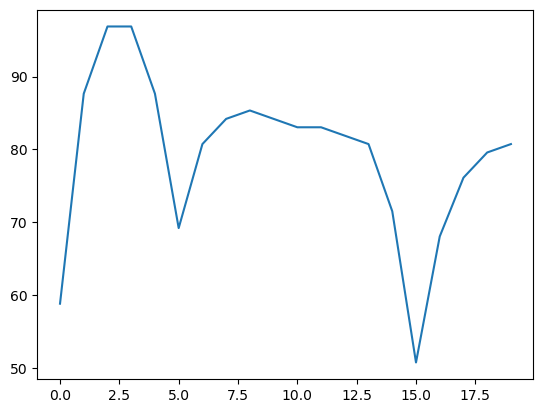

In [23]:
x=np.array(range(expD.shape[0]),dtype=int)
nobsD0 = np.array(expD[f"{cname}_MEAN"])#/np.sum(expD[f"{cname}_MEAN"])
plt.plot(x,nobsD0,label=cname)
plt.show()

In [24]:
cname='D7M3'
obsD = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    obsD[sidx] *= expD[f"{cname}_MEAN"][i]/len(sidx)
nobsD = np.array(expD[f"{cname}_MEAN"])#/np.sum(expD[f"{cname}_MEAN"])
uD = np.concatenate((obsD,obsD))
utrace = [uD,uD]
utrace = np.array(utrace).T
max(obsD)

9.995555556666668

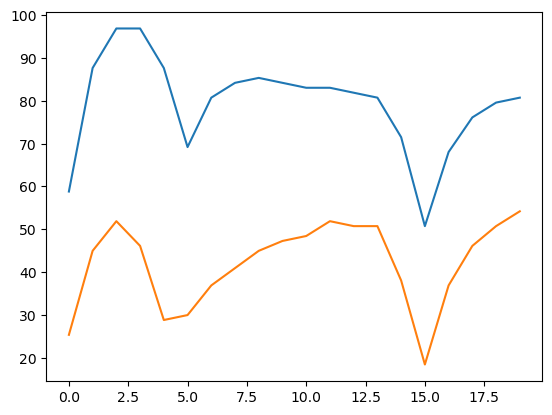

In [25]:
x=np.array(range(expD.shape[0]),dtype=int)

plt.plot(x,nobsD0,label=cname)
plt.plot(x,nobsD,label='detached DC')
plt.show()

In [26]:
diF=abs(uD-u1)
utrace = [diF,diF]
utrace = np.array(utrace).T
(min(diF),max(diF))

(0.0, 13.071111109999999)

In [27]:
cname='D7M3'
obsD = np.ones(len(seg_list))
resMo = np.zeros(expD.shape[0])
resFo = np.zeros(expD.shape[0])
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    obsD[sidx] *= expD[f"{cname}_MEAN"][i]
    resMo[i] = np.sum(utrace[sidx,-1])
    resFo[i] = np.sum(utrace[[j+n for j in sidx],-1])
nobsD = np.array(expD[f"{cname}_MEAN"])/np.sum(expD[f"{cname}_MEAN"])
nobsDnn = np.array(expD[f"{cname}_MEAN"])/np.sum(expD["D0M3_MEAN"])
nresM = resMo/np.sum(resMo)
nresF = resFo/np.sum(resFo)
(nobsD,nresM,nresF)

(array([0.03007519, 0.05331511, 0.06151743, 0.05468216, 0.03417635,
        0.0355434 , 0.04374573, 0.04853042, 0.05331511, 0.05604921,
        0.05741627, 0.06151743, 0.06015038, 0.06015038, 0.04511278,
        0.02187286, 0.04374573, 0.05468216, 0.06015038, 0.06425154]),
 array([0.04499612, 0.05740884, 0.06051202, 0.06826998, 0.07913111,
        0.05275407, 0.05896043, 0.05818464, 0.05430566, 0.04965089,
        0.04654771, 0.04189294, 0.04189294, 0.04034135, 0.04499612,
        0.04344453, 0.04189294, 0.04034135, 0.03878976, 0.03568658]),
 array([0.04499612, 0.05740884, 0.06051202, 0.06826998, 0.07913111,
        0.05275407, 0.05896043, 0.05818464, 0.05430566, 0.04965089,
        0.04654771, 0.04189294, 0.04189294, 0.04034135, 0.04499612,
        0.04344453, 0.04189294, 0.04034135, 0.03878976, 0.03568658]))

In [28]:
par = [1000,0,0,0,0]+[i+1 for i in range(expD.shape[0])]
par

[1000,
 0,
 0,
 0,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20]

In [29]:
i=0
abb = expD['Abbreviation'][i]
sidx = segIdx[abb]
(i,abb,sidx)

(0, 'CA1so_1', [651, 652, 661, 708, 709, 710, 711, 712, 717])

In [30]:
itarg = np.ones(len(seg_list), dtype=int)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx = segIdx[abb]
    itarg[sidx] *= i+5
utarg = [par[j] for j in itarg]
tgAbb = []
tgFnd = []
for i in itarg:
    if i>4:
        tgFnd.append(f'found:{i-5}')#
        tgAbb.append(expD['Abbreviation'][i-5])
    else:
        tgAbb.append('none')
        tgFnd.append('none')
itargDF=pd.DataFrame({'itarg':itarg,'utarg': utarg,'name':sname,'hname':hname,'abbCA1':abbCA1,'tgFnd':tgFnd,'tgAbb':tgAbb})
itargDF

,itarg,utarg,name,hname,abbCA1,tgFnd,tgAbb
0,1,0,soma[0],soma[0],Soma_0,none,none
1,1,0,soma[1],soma[1],Soma_0,none,none
2,10,6,dend_5[0],dend_5[0],CA1sr_1,found:5,CA1sr_1
3,10,6,apic[0],apic[0],CA1sr_1,found:5,CA1sr_1
4,11,7,apic[0],apic[0],CA1sr_2,found:6,CA1sr_2
...,...,...,...,...,...,...,...
737,1,0,axon[0],axon[0],NaN,none,none
738,1,0,axon[0],axon[0],NaN,none,none
739,1,0,axon[0],axon[0],NaN,none,none
740,1,0,axon[0],axon[0],NaN,none,none


In [31]:
#itargDF.to_csv('itarg.csv')

In [32]:
lowb=np.array([0,-18,0,-18,-18,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07,1.0e-07])
upbga=np.array([1,-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
Ndim=len(lowb)
(Ndim,len(lowb),len(upbga))

(25, 25, 25)

In [33]:
bgSignal = 1e-5
cname0='D0M3'
d0w = -1 * np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d0w[sidx] *= -1*expD[f"{cname0}_MEAN"][i]/len(sidx)
for i in range(N):
    if d0w[i]<0:
        d0w[i] = bgSignal
dinit = d0w/np.sum(d0w)

#cname='D7W3'
cname7='D7M3'
d7w = -1*np.ones(N)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    d7w[sidx] *= -1 * expD[f"{cname7}_MEAN"][i]/len(sidx)
for i in range(N):
    if d7w[i]<0:
        d7w[i] = bgSignal
target = np.array(expD[f"{cname7}_MEAN"])/np.sum(expD[f"{cname0}_MEAN"]) #norm target to Day0 sum to take into accound degradation
tnorm = np.sum(target ** 2)
day7 = 7 * 24 * 3600 # final time point

itarg = np.ones(N, dtype=int)
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx = segIdx[abb]
    itarg[sidx] *= (i+5)

def getUmatrix(par, t, p,a_s,b_s,delta=bgSignal):
    F = par[0]
    Ctau = 10 ** par[1]
    mProp = par[2]
    dvA = par[3]
    dvB = par[4]
    dv = np.zeros(N)
    utarg = delta*np.ones(N)
    for k in range(N):
        if itarg[k] > 4:
            utarg[k] = par[itarg[k]]
            dv[k] = (10 ** dvA) + (10 ** dvB)*utarg[k]
    utarg /= np.sum(utarg)
    K = np.sum(utarg) / N
    x = trafficking_solution(F * utarg + (1 - F) * K)
    a = (1 / (1 + x))
    a[0] = a_s
    a[1] = a_s
    a = list(a)
    b = (1 / (1 + x ** -1))
    b[0] = b_s
    b[1] = b_s
    b = list(b)
    l = list(dv)
    c = list(Ctau * utarg / (F * utarg + (1 - F) * K))
    d = list(np.zeros(N))
    print(f"t={t}, p={p}, a_s={a_s}, b_s={b_s}")
    A = sushi_system(a, b, c, d, l,t,p)
    u0 = np.concatenate((mProp * dinit, (1 - mProp) * dinit,np.ones(1)))
    #utrace = sim_time(A, u0, day7)
    return u0,A

#par = [0.111784701917933,-1,0.584647952749801,-5.40926182202759,-7.58373647291078,0.93075347720533,0.150119155946245,0.250026616923097,0.247923892623914,1,0.829698078092076,0.799680386796054,0.435204401984173,0.776990953492751,0.658564397472255,0.669466722069782,0.13217494651507,0.452337127435389,0.818398235362628,0.287266237055001,0.693374804035749,0.387600533946115,0.860396244028168,0.793857689742176,0.00234423876609767]
#cost=0.2289827
#par = [0.141527769926587,-1.04440055844237,0.381706990604462,-5.43766625150405,-12.234744035647,1,0.164098437336494,0.272405308568442,0.427804635567134,0.812746641751752,0.919149761897559,0.672064846552212,0.149965791068772,0.539839422213906,0.812188937409397,0.806685239524521,0.165041822978698,0.529423937850048,0.828384035574742,0.221525313745652,0.676304529167494,0.634182580029409,0.814899037032692,0.790009814378913,0.0884319910464033]
#cost=0.1914477
#par = [1.0,-18.0,0.339665263904274,-18.0,-0.1056091212860899,1.0,0.06274608035463802,4.4574543322602384e-07,0.02193672327975435,0.0870196802604857,8.738149616920519e-07,1.0,0.23641992030781905,0.20499095398769174,3.3139951083305927e-07,0.0264354594647535,1.0601425384202188e-07,0.018642526550405554,1.3229426155908984e-07,0.321659768251798,1.256853193752937e-06,0.9999991575763989,0.9008918582308576,1.0002936595814933e-07,1.0]
#cost = 0.00972634
#par = [0.18124010722657255,-18.0,0.4770849437408547,-18.0,-7.528208406834074,0.6335729107600226,0.28276999275111847,0.558910113544302,1.0,0.3929830308454687,0.2992123958197709,0.753091076326252,1.0,0.17238067898531845,1.0,1e-07,1.0,0.04290036974800929,0.9692956552909402,1.0,0.5346212757781438,1.0,0.28625682786833306,1e-07,1e-07]
#cost = 0.02659
par = [0.32023059450279123,-6.327308855004608,0.627385538130974,-18.0,-17.999431588729976,0.06854654347167044,0.060486839296889444,0.04484900714349323,0.03490854158366522,0.00024252729610862994,0.32943753444660906,0.4029203029951907,0.12801603593190886,0.14871930210853104,0.14171491277653797,0.18024101228415457,0.18628112282529372,0.23357327869041905,0.4302044118823936,0.5008667022509936,0.0038157043176590766,0.2007104314288199,0.22494314014617123,0.31189759389623783,0.9999999999990268]
cost = 0.001142
#par = [0.01385481065982917,-6.226265838840085,0.6709771115511489,-17.995913305482574,-16.696101588995024,0.21868548101204954,0.06211405206769383,0.048882353452234434,0.046632773486508856,1.9401449712242143e-06,0.7864443640945032,0.5632548318074286,0.14915702983161863,0.1491589398028194,0.13322800132469398,0.15668388533325328,0.17435550169553826,0.20436446923690443,0.37541096611836217,0.5260391371129066,0.043995168941356404,0.1970021740399707,0.19622524557390722,0.2758337024352678,0.9999999999613025]
#cost = 1.51e-09
#utrace = calcUtrace(par)
u0,A = getUmatrix(par, t = 1e-5, p = 0.5, a_s=0.7,b_s=0.7)
(A.shape,[(i,A[i,2*N]) for i in range(A.shape[0]) if A[i,2*N] !=0])

t=1e-05, p=0.5, a_s=0.7, b_s=0.7
t=1e-05, p=0.5, N=742
(5e-06, 5e-06, 5e-06, 5e-06)


((1485, 1485), [(0, 5e-06), (1, 5e-06), (742, 5e-06), (743, 5e-06)])

In [34]:
u1 = np.zeros(2*N+1)
u1[-1] = 1
initTime=time.time()
utrace = sim_time(A, u1, day7)
FinalTime=time.time()-initTime
print(FinalTime)
utrace.shape

17.243165969848633


(1485, 11)

In [35]:
initTime=time.time()
utraceS,timeS = sushibelt.run_sim(h,A, npools=2,tmax=day7*1.5,t0=0.316,dt=5)
FinalTime=time.time()-initTime
print(FinalTime)
(utraceS.shape,timeS.shape)

21.9862380027771


((12, 1485), (12,))

In [36]:
utraceS=utraceS.T
t = np.concatenate((np.zeros(1),np.logspace(-0.5,math.log10(day7),10)))
([(min(utrace[:,i]),max(utrace[:,i]),t[i]) for i in range(utrace.shape[1])],
print(utraceS.shape),
[(min(utraceS[:,i]),max(utraceS[:,i]),timeS[i]) for i in range(utrace.shape[1])])

(1485, 12)


([(0.0, 1.0, 0.0),
  (-1.9073486328125e-06, 1.0, 0.31622776601683794),
  (-1.9073486328125e-06, 1.0, 1.5774545849497055),
  (-3.814697265625e-06, 1.0, 7.8688946227648815),
  (-3.814697265625e-06, 1.0, 39.25279572226307),
  (-3.814697265625e-06, 1.0, 195.80665975068456),
  (-7.62939453125e-06, 1.0, 976.7520324921683),
  (-3.814697265625e-06, 1.0, 4872.3804092891505),
  (-3.814697265625e-06, 1.0, 24305.135861608826),
  (0.0, 1.0, 121242.50974431788),
  (0.0, 1.0, 604800.0)],
 None,
 [(0.0, 1.0, 0.0),
  (2.2831135710033117e-92, 1.0, 0.316),
  (1.4234247629269127e-81, 1.0, 1.58),
  (1.2770969893529749e-49, 1.0, 7.9),
  (4.0012446727735775e-26, 1.0, 39.5),
  (4.340806766892092e-16, 1.0, 197.5),
  (6.779929423890977e-13, 1.0, 987.5),
  (1.4724534361329318e-11, 1.0, 4937.5),
  (2.0774091146238764e-10, 1.0, 24687.5),
  (3.781215571278398e-09, 1.0, 123437.5),
  (8.038662640201971e-08, 3.08593758039357, 617187.5)])

In [37]:
t = np.concatenate((np.zeros(1),np.logspace(-0.5,math.log10(day7),10)))

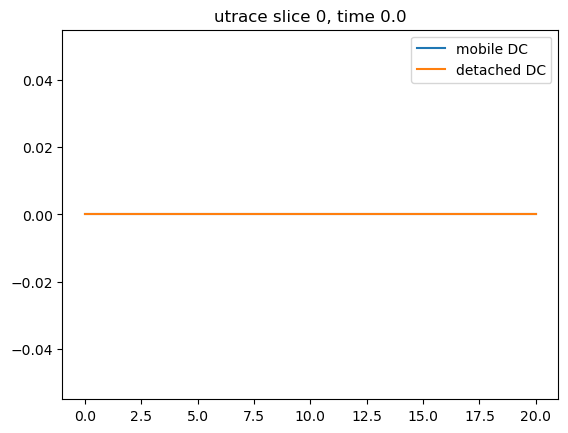

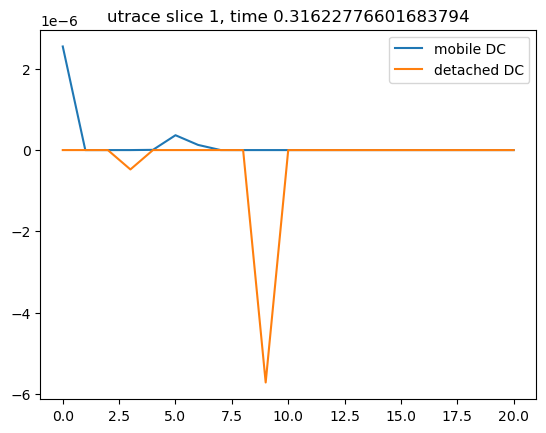

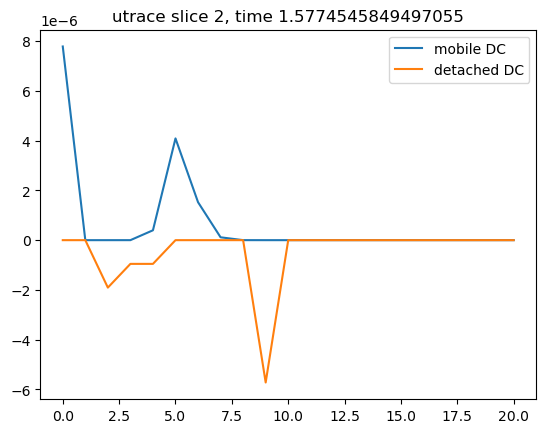

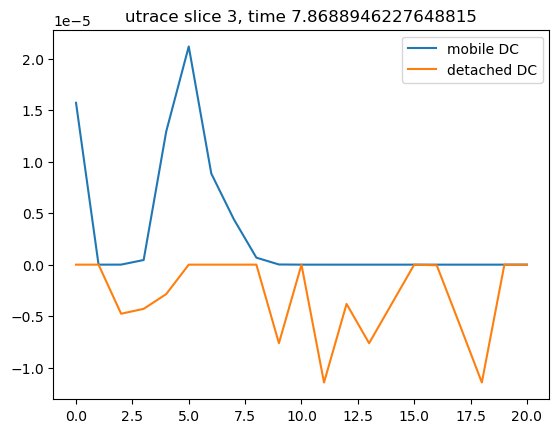

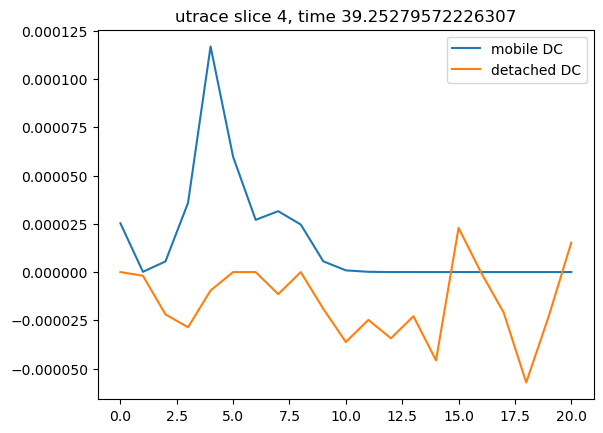

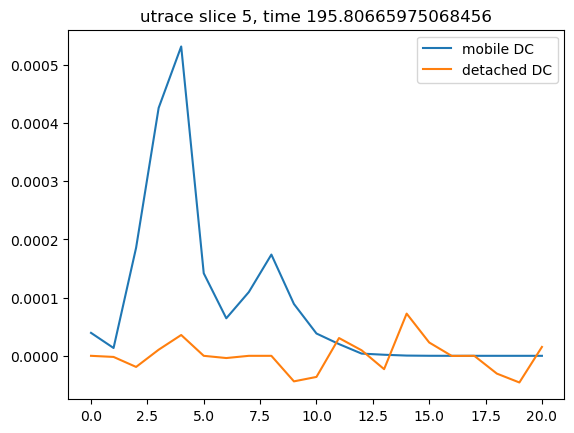

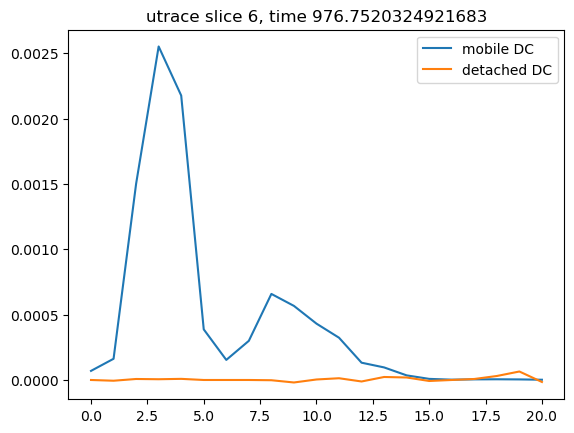

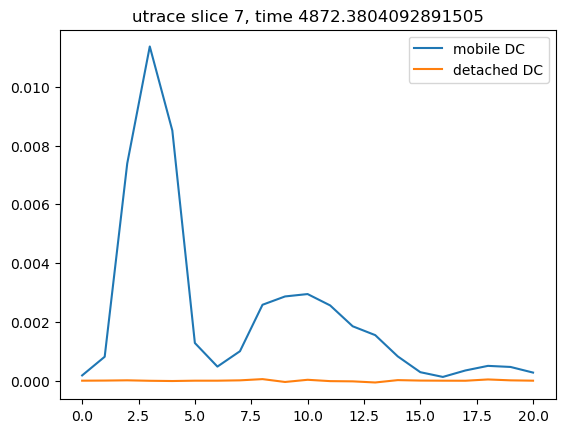

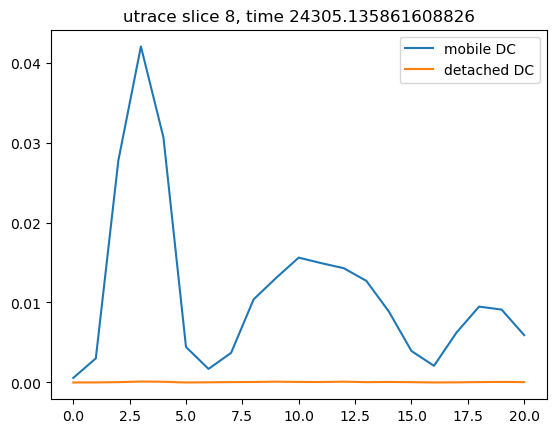

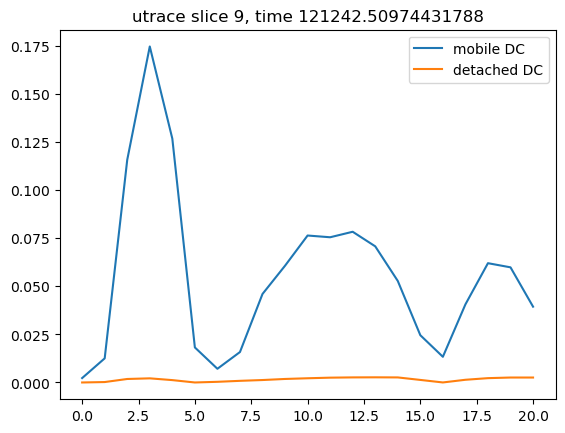

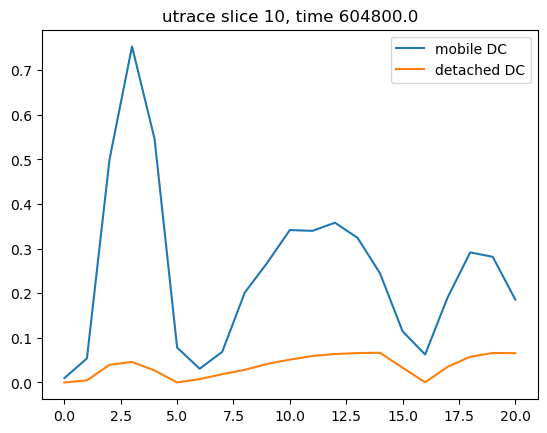

In [38]:
abb_names = ['Soma_0']+[s for s in expD['Abbreviation']]
x=np.array(range(expD.shape[0]+1),dtype=int)
for i in range(utrace.shape[1]):
    resM, resF = sushibelt.aggregate_segments(utrace[:-1, i], segIdx, abb_names, fun=np.sum)
    plt.plot(x,resM,label='mobile DC')
    plt.plot(x,resF,label='detached DC')
    plt.legend()
    plt.title(f"utrace slice {i}, time {t[i]}") 
    plt.show()

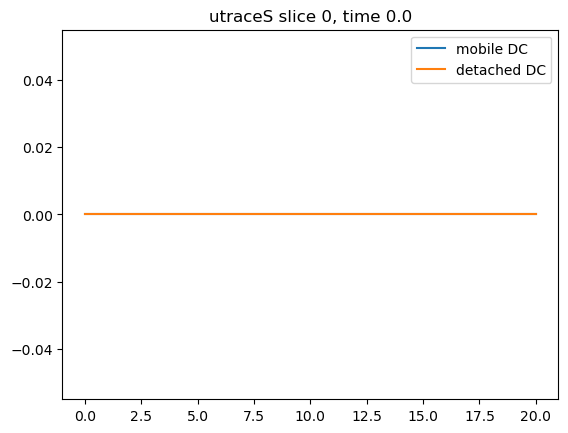

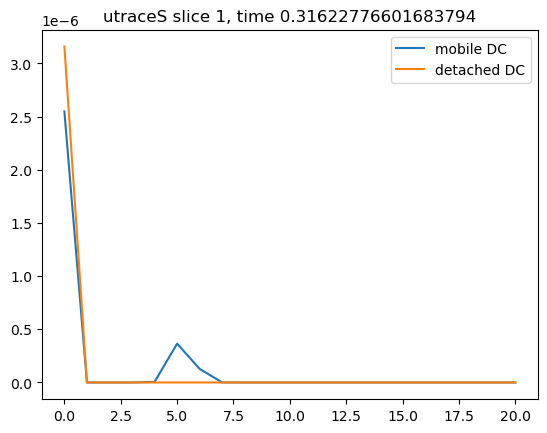

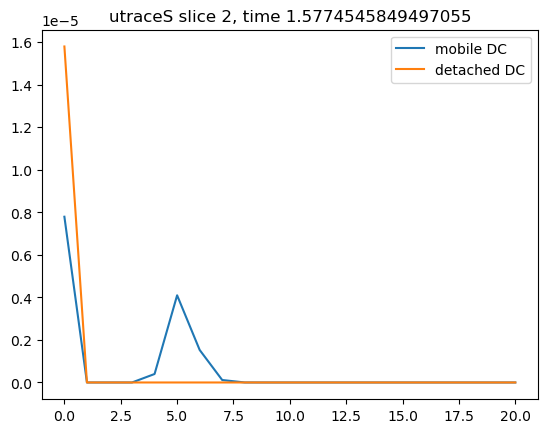

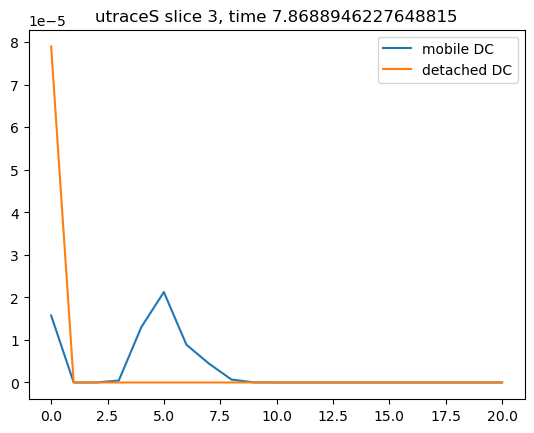

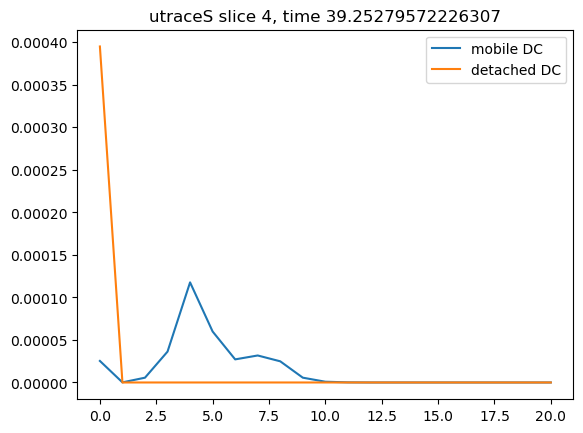

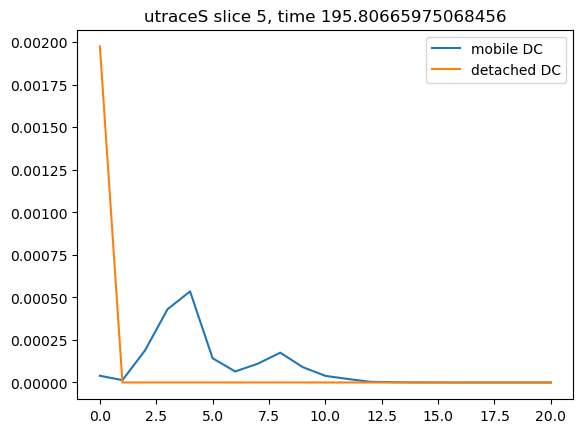

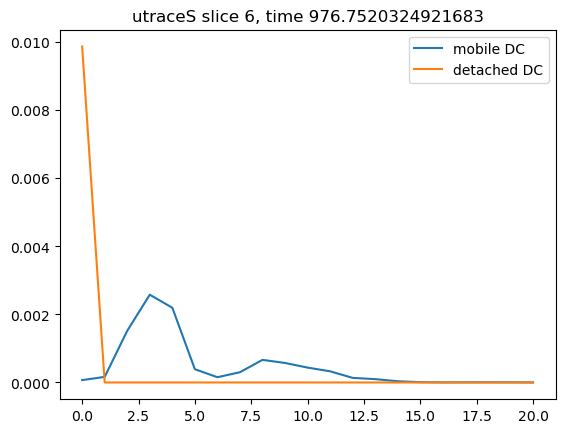

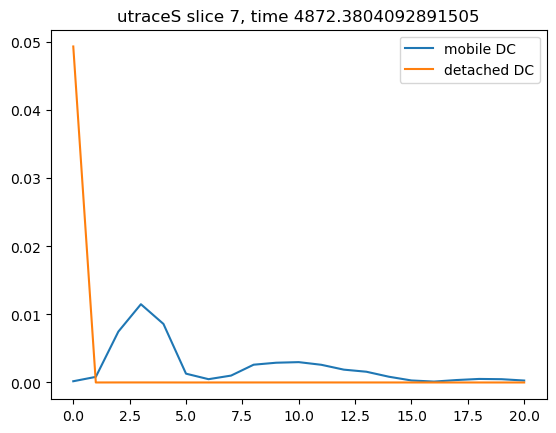

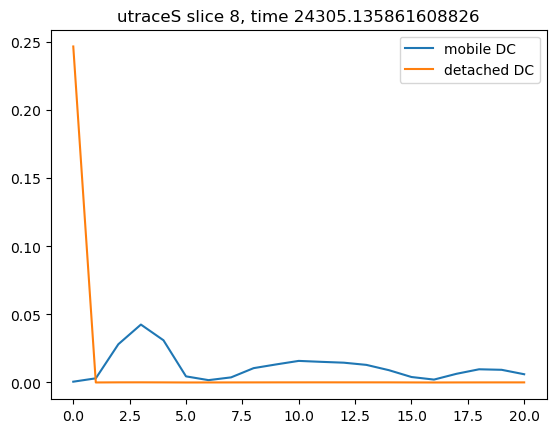

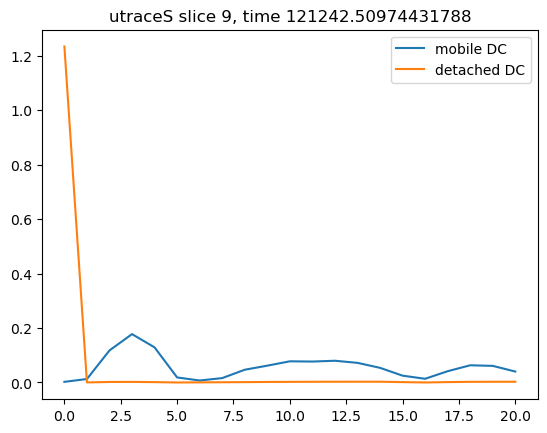

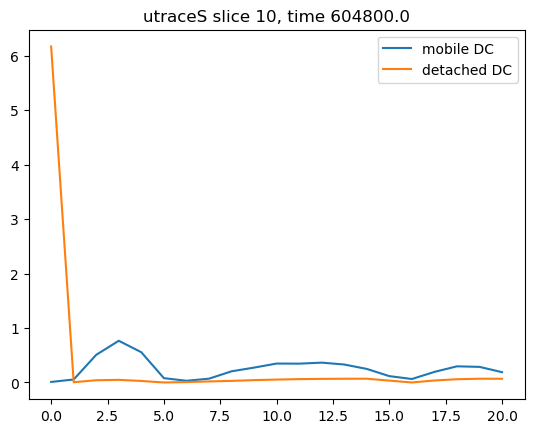

In [39]:
abb_names = ['Soma_0']+[s for s in expD['Abbreviation']]
x=np.array(range(expD.shape[0]+1),dtype=int)
for i in range(utrace.shape[1]):
    resM, resF = sushibelt.aggregate_segments(utraceS[:-1, i], segIdx, abb_names, fun=np.sum)
    plt.plot(x,resM,label='mobile DC')
    plt.plot(x,resF,label='detached DC')
    plt.legend()
    plt.title(f"utraceS slice {i}, time {t[i]}") 
    plt.show()

In [40]:
(x[:10],x[10:20],isinstance(x[0],list),x[0]==int(x[0]))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
 False,
 True)

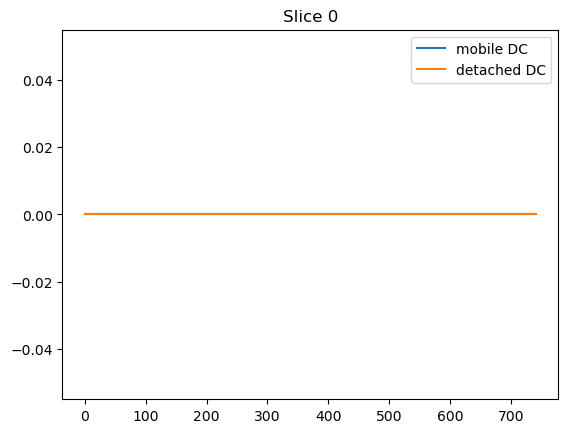

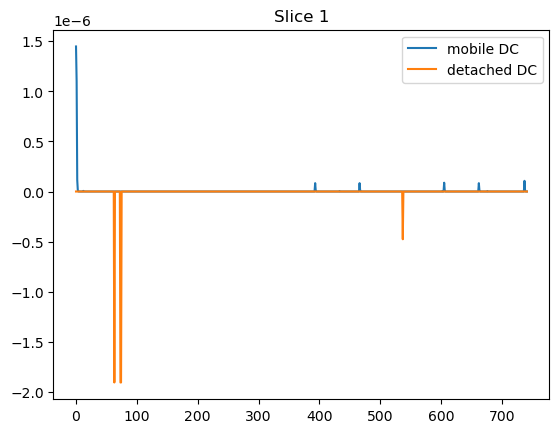

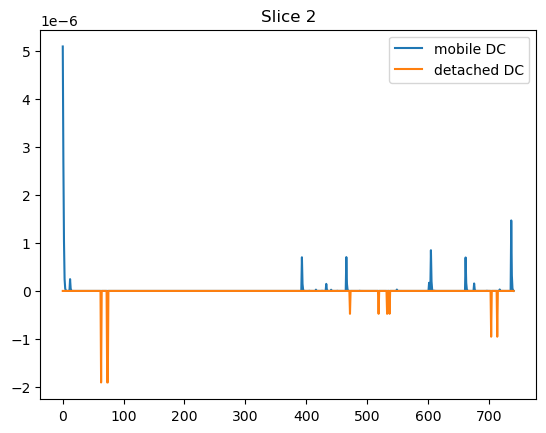

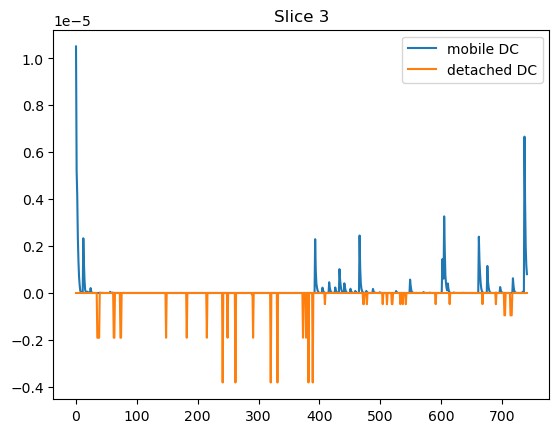

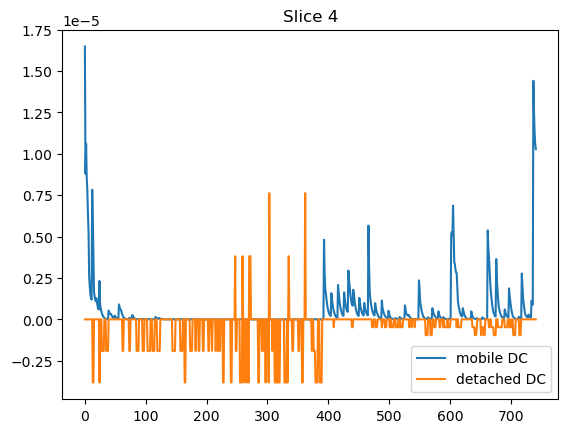

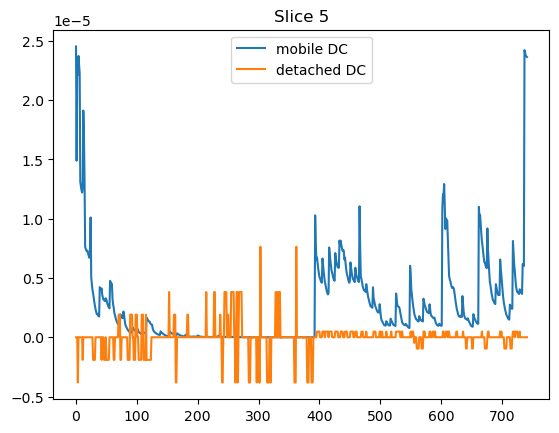

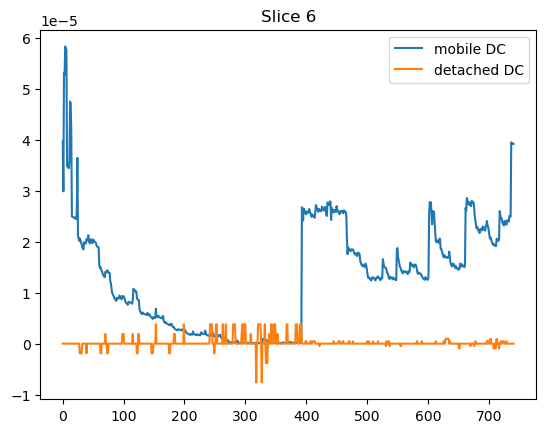

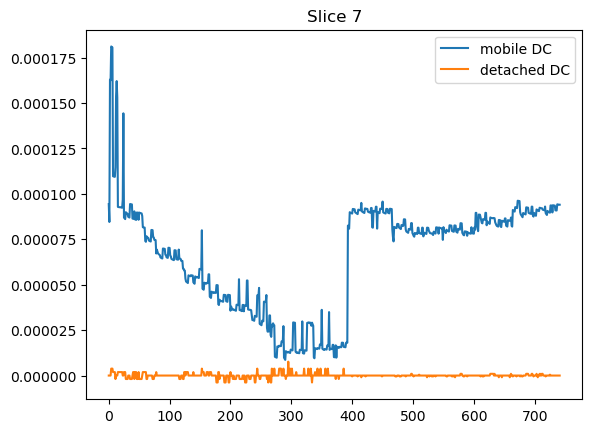

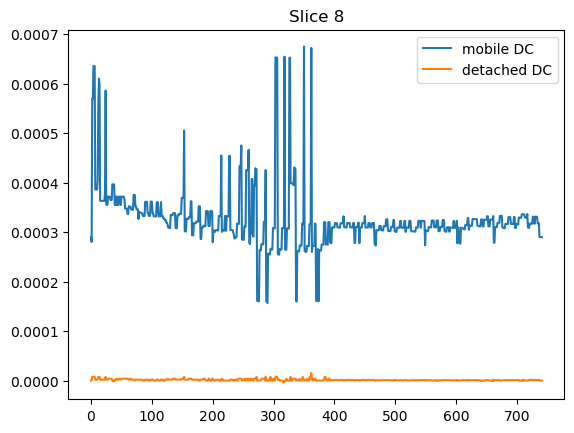

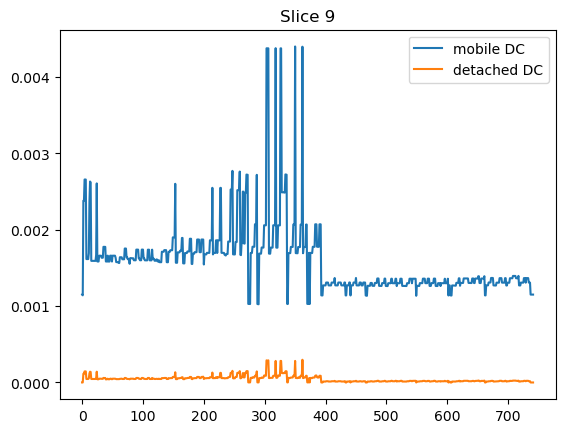

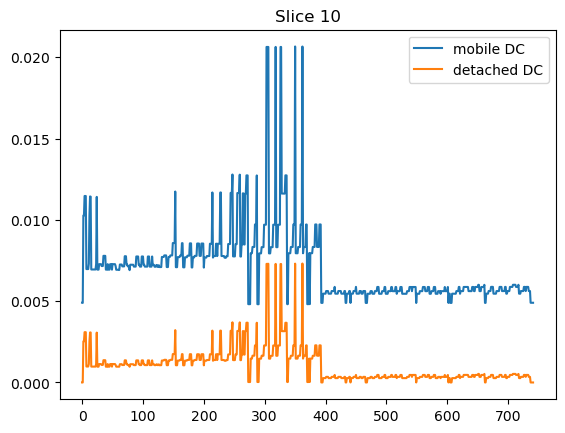

In [41]:
abb_names = ['Soma_0']+[s for s in expD['Abbreviation']]
x=np.array(range(N),dtype=int)
for i in range(utrace.shape[1]):
    resM = utrace[:N, i]
    resF = utrace[N:-1, i]
    plt.plot(x,resM,label='mobile DC')
    plt.plot(x,resF,label='detached DC')
    plt.legend()
    plt.title(f"Slice {i}") 
    plt.show()

In [42]:
(utrace[0,:],utrace[N,:],utraceS[0,:],utraceS[N,:],[A[i,2*N] for i in range(A.shape[0]) if A[i,2*N] != 0],A.shape,
[A[2*N,i] for i in range(A.shape[0]) if A[2*N,i] != 0],
utrace[2*N,:],utraceS[2*N,:],utrace.shape,utraceS.shape)

(array([0.00000000e+00, 1.44851942e-06, 5.09330052e-06, 1.05082364e-05,
        1.64883838e-05, 2.45273272e-05, 3.97360763e-05, 9.43944623e-05,
        2.90102148e-04, 1.15113842e-03, 4.90271522e-03]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.00000000e+00, 1.44757277e-06, 5.09835745e-06, 1.05215575e-05,
        1.65173944e-05, 2.45738189e-05, 3.99176848e-05, 9.52011257e-05,
        2.93618987e-04, 1.17016793e-03, 4.98805660e-03, 1.50195749e-02]),
 array([0.00000000e+00, 1.58000000e-06, 7.90000000e-06, 3.95000000e-05,
        1.97500000e-04, 9.87500000e-04, 4.93750000e-03, 2.46875000e-02,
        1.23437500e-01, 6.17187504e-01, 3.08593758e+00, 1.54296889e+01]),
 [5e-06, 5e-06, 5e-06, 5e-06],
 (1485, 1485),
 [],
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 (1485, 11),
 (1485, 12))

In [43]:
[(i,utrace[i,1],sname[i]) for i in range(N) if utrace[i,1]>1e-9]

[(0, 1.4485194187244255e-06, 'soma[0]'),
 (1, 1.1023282171195026e-06, 'soma[1]'),
 (2, 1.1524284990876987e-07, 'dend_5[0]'),
 (3, 6.142202260694951e-09, 'apic[0]'),
 (12, 6.14220208028371e-09, 'dend_5[1]'),
 (393, 8.349029316859213e-08, 'dend[59]'),
 (394, 4.302753781743052e-09, 'dend[67]'),
 (433, 4.312112514281985e-09, 'dend[60]'),
 (466, 8.349556753634024e-08, 'dend[28]'),
 (467, 4.312250858479194e-09, 'dend[30]'),
 (602, 4.470820418739363e-09, 'dend[29]'),
 (605, 8.780279095801924e-08, 'dend[15]'),
 (606, 4.654126254527435e-09, 'dend[15]'),
 (662, 8.325948103182768e-08, 'dend[0]'),
 (663, 4.461318627024813e-09, 'dend[14]'),
 (676, 4.5486553586215894e-09, 'dend[1]'),
 (737, 1.065838276491371e-07, 'axon[0]'),
 (738, 5.410652013232431e-09, 'axon[0]')]

In [44]:
t = np.logspace(-0.5,math.log10(day7),10)
(t,[t[i+1]/t[i] for i in range(len(t)-1)])

(array([3.16227766e-01, 1.57745458e+00, 7.86889462e+00, 3.92527957e+01,
        1.95806660e+02, 9.76752032e+02, 4.87238041e+03, 2.43051359e+04,
        1.21242510e+05, 6.04800000e+05]),
 [4.988349393916637,
  4.988349393916636,
  4.988349393916636,
  4.988349393916637,
  4.988349393916636,
  4.988349393916637,
  4.988349393916637,
  4.988349393916636,
  4.988349393916637])

2.6833009719848633
7.737196997444804e-08 3.0240000773787954


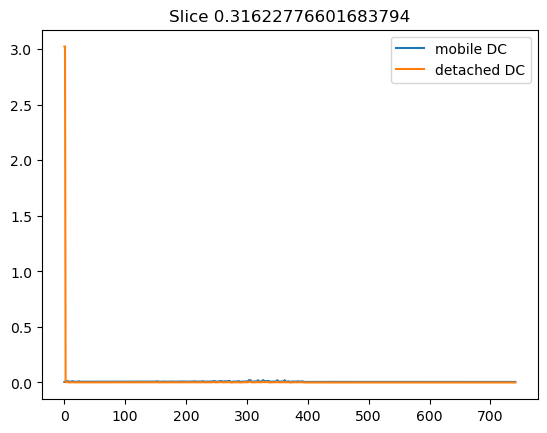

In [45]:
initTime=time.time()
res=np.dot(expm(t[-1] * A), u1)
FinalTime=time.time()-initTime
print(FinalTime)
resM = res[:N]
resF = res[N:-1]
print(min(res),max(res))
x=np.array(range(N),dtype=int)
plt.plot(x,resM,label='mobile DC')
plt.plot(x,resF,label='detached DC')
plt.legend()
plt.title(f"Slice {t[0]}") 
plt.show()

In [46]:
initTime=time.time()
w,V = scipy.linalg.eig(A)
Vinv = np.linalg.inv(V)
resS=solve_u(u1,w,V,Vinv,t[-1])
FinalTime=time.time()-initTime
print(FinalTime)


13.350133895874023


In [47]:
(V.shape,np.linalg.matrix_rank(V))

((1485, 1485), 1484)

In [ ]:
A_reat=A.copy()
# transcription to detached RNA only
A_reat[0,2*N] = 0
A_reat[N,2*N] *= 2
A_reat[1,2*N] = 0
A_reat[N+1,2*N] *= 2
A_reat[N+1,2*N] *= 2
dd = 1e-3
for i in range(2):
    # reattachment
    A_reat[i, i + N] += dd
    A_reat[i + N, i + N] += -dd


In [ ]:
A_reat.shape

In [ ]:
initTime=time.time()
utraceR,timeR = sushibelt.run_sim(h,A_reat, npools=2,tmax=day7*1.5,t0=0.316,dt=5)
FinalTime=time.time()-initTime
print(FinalTime)
utraceR=utraceR.T
(utraceR.shape,timeR.shape)

In [ ]:
abb_names = ['Soma_0']+[s for s in expD['Abbreviation']]
x=np.array(range(expD.shape[0]+1),dtype=int)
for i in range(utrace.shape[1]):
    resM, resF = sushibelt.aggregate_segments(utraceR[:-1, i], segIdx, abb_names, fun=np.sum)
    plt.plot(x,resM,label='mobile DC')
    plt.plot(x,resF,label='detached DC')
    plt.legend()
    plt.title(f"utraceS slice {i}, time {timeR[i]}") 
    plt.show()

In [ ]:
(utraceR[0,:],utraceR[N,:])

In [ ]:
initTime=time.time()
res=np.dot(expm(1e10 * A_reat), u1)
FinalTime=time.time()-initTime
print(FinalTime)
resM = res[:N]
resF = res[N:-1]
print(min(res),max(res))
x=np.array(range(N),dtype=int)
plt.plot(x,resM,label='mobile DC')
plt.plot(x,resF,label='detached DC')
plt.legend()
plt.title(f"Steady-state") 
plt.show()

In [ ]:
(np.sum(resM),np.sum(resF))

In [ ]:
#snap_ss(f"reg20_{cname}_target",clim=[min(utrace[:,-1]),max(utrace[:,-1])],cmap=plt.cm.YlOrBr)

In [ ]:
par = [0.32023059450279123,-6.327308855004608,0.627385538130974,-18.0,-17.999431588729976,0.06854654347167044,0.060486839296889444,0.04484900714349323,0.03490854158366522,0.00024252729610862994,0.32943753444660906,0.4029203029951907,0.12801603593190886,0.14871930210853104,0.14171491277653797,0.18024101228415457,0.18628112282529372,0.23357327869041905,0.4302044118823936,0.5008667022509936,0.0038157043176590766,0.2007104314288199,0.22494314014617123,0.31189759389623783,0.9999999999990268]
cost = 0.001142
delta=bgSignal
F = par[0]
Ctau = 10 ** par[1]
mProp = par[2]
dvA = par[3]
dvB = par[4]
dv = np.zeros(N)
utarg = delta*np.ones(N)
for k in range(N):
    if itarg[k] > 4:
        utarg[k] = par[itarg[k]]
        dv[k] = (10 ** dvA) + (10 ** dvB)*utarg[k]
utarg /= np.sum(utarg)
K = np.sum(utarg) / N
x = trafficking_solution(F * utarg + (1 - F) * K)
a = (1 / (1 + x))
b = (1 / (1 + x ** -1))
(a[:11],b[:11],min(a),max(a),min(b),max(b))

In [ ]:
{'F' : par[0],
'Ctau' : 10 ** par[1],
'mProp' : par[2],
'dvA': 10 ** par[3],
'dvB': 10 ** par[4],
'demand_CA1so_1' : par[5],
'demand_CA1so_2' : par[6],
'demand_CA1so_3' : par[7],
'demand_CA1so_4' : par[8],
'demand_CA1so_5' : par[9],
'demand_CA1sr_1' : par[10],
'demand_CA1sr_2' : par[11],
'demand_CA1sr_3' : par[12],
'demand_CA1sr_4' : par[13],
'demand_CA1sr_5' : par[14],
'demand_CA1sr_6' : par[15],
'demand_CA1sr_7' : par[16],
'demand_CA1sr_8' : par[17],
'demand_CA1sr_9' : par[18],
'demand_CA1sr_10' : par[19],
'demand_CA1slm_1' : par[20],
'demand_CA1slm_2' : par[21],
'demand_CA1slm_3' : par[22],
'demand_CA1slm_4' : par[23],
'demand_CA1slm_5' : par[24],
'sum_nobsDnn' : np.sum(nobsDnn),
'sum_nobsDnn^2' : np.sum(nobsDnn ** 2),
'sum_resM' : np.sum(resM),
'sum_resF' : np.sum(resF),
'sum_tot' : np.sum(resF)+np.sum(resM),
'err' : np.sum((resF - target) ** 2),
'err_norm' : np.sum((resF - target) ** 2)/tnorm,
'cost' : cost
}

In [ ]:
x=np.array(range(expD.shape[0]),dtype=int)

plt.plot(x,target,label=cname)
#plt.plot(x,nresM,label='mobile O')
#plt.plot(x,nresF,label='detached O')
plt.plot(x,resM,label='mobile DC')
plt.plot(x,resF,label='detached DC')
plt.ylabel('Value')
plt.xlabel('Region number')
# show a legend on the plot
plt.legend()
plt.title(f"Cost = {cost}") 
# function to show the plot
#plt.show()
plt.savefig('bestFitEdita_20reg_1dv_202404151015.png')
plt.savefig('bestFitEdita_20reg_1dv_202404151015.pdf')
plt.savefig('bestFitEdita_20reg_1dv_202404151015.svg')


In [ ]:
plt.plot(x,target,label=cname)
#plt.plot(x,nresM,label='mobile O')
plt.plot(x,resF,label='detached O')
#plt.plot(x,resM+resF,label='total DC')
plt.ylabel('Value')
plt.xlabel('Region number')
# show a legend on the plot
plt.legend()
plt.title(f"Cost = {cost}") 
plt.savefig('bestFitEdita_20reg_1dv_resF202404151015.png')
plt.savefig('bestFitEdita_20reg_1dv_resF202404151015.pdf')
plt.savefig('bestFitEdita_20reg_1dv_resF202404151015.svg')


In [ ]:
F = par[0]
Ctau = 10 ** par[1]
mProp = par[2]
dv = np.zeros(n)
utarg = bgSignal*np.ones(n)
for k in range(n):
    if itarg[k] > 2:
        dv[k] = 10 ** par[itarg[k]]
        utarg[k] = par[itarg[k]+3]
    else:
        dv[k] = np.nan
        utarg[k] = np.nan
#utarg /= np.sum(utarg)
bfit, afit = np.polyfit(par[6:], 10 ** np.array(par[3:6]), deg=1)
xseq = np.linspace(min(par[6:]), max(par[6:]), num=100)
#plt.scatter(utarg,dv)
fig, ax = plt.subplots(figsize = (9, 9))
ax.scatter(par[6:], 10 ** np.array(par[3:6]))
ax.plot(xseq, afit + bfit * xseq, color="k", lw=2.5)
ax.text(0, 5.3e-6, f'LR equation: $Y = {round(afit*1e6,3)}'+'\\ 10^{-6}'+f' + {round(bfit*1e6,3)}'+'\\ 10^{-6}\\ X$', fontsize=10)
plt.xlabel('Demand value')
plt.ylabel('Degradation rate')
#plt.show()
plt.savefig('bestFitEdita_3dv_scatter_20240403.png')
plt.savefig('bestFitEdita_3dv_scatter_20240403.pdf')
plt.savefig('bestFitEdita_3dv_scatter_20240403.svg')


In [ ]:
bfit, afit = np.polyfit(par[6:], 10 ** np.array(par[3:6]), deg=1)
plt.plot(xseq, afit + bfit * xseq, color="k", lw=2.5)
(bfit, afit,f'LR equation: $Y = {round(afit*1e6,3)}'+'\\ 10^{-6}'+f' + {round(bfit*1e6,3)}'+'\\ 10^{-6}\\ X$')

Day 7 3 weeks
----

In [ ]:
cname='D7W3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case1_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

In [ ]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=1e-5,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case1_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 0 3 month
----

In [ ]:
cname='D0M3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case1_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

In [ ]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=1e-5,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case1_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 7 3 month
----

In [ ]:
cname='D7M3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case1_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

In [ ]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=1e-5,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case1_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 0 18 month
----

In [ ]:
cname='D0M18'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case1_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

In [ ]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=1e-5,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case1_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 7 18 month
----

In [ ]:
cname='D7M18'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case1_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

In [ ]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=1e-5,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case1_{cname}")

# animation
#animate_sim()
print(FinalTime)

Second Case: timescales not separated, proximal inputs are *greedy* and prevent distal transport
----

Day 0 3 weeks
----

In [ ]:
cname='D0W3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case2_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

In [ ]:
# Run simulation
utarg /= np.sum(utarg)
initTime=time.time()
A = get_sys_matrix(utarg,F=1,Ctau=1e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case2_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 7 3 weeks
----

In [ ]:
cname='D7W3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case2_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

In [ ]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=1,Ctau=1e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case2_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 0 3 month
----

In [ ]:
cname='D0M3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case2_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

In [ ]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=1,Ctau=1e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case2_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 7 3 month
----

In [ ]:
cname='D7M3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case2_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

In [ ]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=1,Ctau=1e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case2_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 0 18 month
----

In [ ]:
cname='D0M18'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case2_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

In [ ]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=1,Ctau=1e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case2_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 7 18 month
----

In [ ]:
cname='D7M18'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case2_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

In [ ]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=1,Ctau=1e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case2_{cname}")

# animation
#animate_sim()
print(FinalTime)

Third Case: Time scales separated, different trafficking strategy
------

Day 0 3 weeks
----

In [ ]:
cname='D0W3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case3_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

In [ ]:
# Run simulation
utarg /= np.sum(utarg)
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=2e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case3_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 7 3 weeks
----

In [ ]:
cname='D7W3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case3_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

In [ ]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=2e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case3_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 0 3 month
----

In [ ]:
cname='D0M3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case3_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

In [ ]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=2e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case3_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 7 3 month
----

In [ ]:
cname='D7M3'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case3_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

In [ ]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=2e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case3_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 0 18 month
----

In [ ]:
cname='D0M18'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case3_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

In [ ]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=2e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case3_{cname}")

# animation
#animate_sim()
print(FinalTime)

Day 7 18 month
----

In [ ]:
cname='D7M18'
utarg = np.ones(len(seg_list))
for i in range(expD.shape[0]):
    abb = expD['Abbreviation'][i]
    sidx= segIdx[abb]
    utarg[sidx] *= expD[f"{cname}_MEAN"][i]
u1 = np.concatenate((utarg,utarg))
utrace = [u1,u1]
utrace = np.array(utrace).T
snap_ss(f"case3_{cname}_target",clim=[0,max(utarg)],cmap=plt.cm.YlOrBr)
max(utarg)

In [ ]:
utarg /= np.sum(utarg)

# Run simulation
initTime=time.time()
A = get_sys_matrix(utarg,F=0,Ctau=2e-4,dv=1e-9)
utrace = run_sim(A)
FinalTime=time.time()-initTime

# snapshot of steady-state
snap_ss(f"case3_{cname}")

# animation
#animate_sim()
print(FinalTime)

In [ ]:
utrace[743:753,10]

Third Case: protein + RNA
----

In [ ]:
initTime=time.time()
A,u,t,excess,err = sushibelt.run_uniform_reattachment(h, 0.1, 5, 50.0, 1e-5,1e-6)
FinalTime=time.time()-initTime
print(FinalTime)
#sushibelt.snapshots(h,u,t,'plots/with_reattach',cellname,view,u_cmap,us_cmap)
#print 'excess cargo = %2.1f percent'%(excess[-1])

In [ ]:
N
utrace=u[:,:2*N]
utrace=utrace.T

In [ ]:
A.shape

In [ ]:
t.shape

In [ ]:
u.shape

In [ ]:
nframes=50
t = np.logspace(-0.5,8.5,nframes)
t.shape

In [ ]:
u0 = np.zeros(4*n)
u0[0] = 1.0  # compartment 0 is the soma
initTime=time.time()
utrace = [u0]
w,V = scipy.linalg.eig(A)
Vinv = np.linalg.inv(V)
t = np.logspace(-0.5,8.5,nframes)
for t_ in t: utrace.append(solve_u(w,V,Vinv,t_))

FinalTime=time.time()-initTime
print(FinalTime)


cvals=utrace[:,-1]
cvals.shape

In [ ]:
(1484/len(seg_list),len(seg_list))

In [ ]:
t.shape

In [ ]:
[d/4 for d in A.shape]

In [ ]:
(1484*2,A.shape)

In [ ]:
max(dts)

In [ ]:
from PyNeuronToolbox.morphology import shapeplot, allsec_preorder, root_indices, shapeplot_animate
roots = root_indices(allsec_preorder(h))
roots

In [ ]:
import pandas as pd
fitdt = pd.read_csv('data/Distr.csv')

In [ ]:
idx = []
for i in range(n):
    if abs(dts[i]-100)<1 :
        idx.append(1)
    else:
        idx.append(0)
sum(idx)

In [ ]:
[ (i,j) for i in range(fitdt.shape[0]) for j in range(n) if abs(dts[j]-fitdt['X'][i])<1 ]

In [ ]:
type(fitdt)

In [ ]:
seg_idx = [(i, j) for i in range(fitdt.shape[0]) for j in range(n) if abs(dts[j] - fitdt['X'][i]) < 1]
len(seg_idx)

In [ ]:
inum=3
ix=[ i for i in range(3*inum)]
(ix[:inum],ix[inum:2*inum],ix[2*inum:])

In [ ]:
[ max(u[:,r]) for r in range(u.shape[0])]

In [ ]:
range(u.shape[1])

In [ ]:
    clim=[0,0.00022]
    uplt = u[:,n:2*n]
    uplt = uplt.T
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,cvals=uplt[:,1],clim=clim,\
                      cmap=plt.cm.cool,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('free RNA 1',fontweight='bold',fontsize=14)

    # colorbar
    sm = cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    #sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    #sm._A = []
    #plt.colorbar(sm, shrink=0.5)
    #plt.colorbar(sm,cax=shapeax)
    #plt.colorbar()
    plt.tight_layout()
    plt.axis('off')


In [ ]:
    clim=[0,0.00022]
    uplt = u[:,:n]
    uplt = uplt.T
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,cvals=uplt[:,-1],clim=clim,\
                      cmap=plt.cm.cool,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('bounded RNA -1',fontweight='bold',fontsize=14)

    # colorbar
    sm = cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    #sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    #sm._A = []
    #plt.colorbar(sm, shrink=0.5)
    #plt.colorbar(sm,cax=shapeax)
    #plt.colorbar()
    plt.tight_layout()
    plt.axis('off')


In [ ]:
    clim=[0,0.00022]
    uplt = u[:,2*n:3*n]
    uplt = uplt.T
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,cvals=uplt[:,-1],clim=clim,\
                      cmap=plt.cm.cool,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('bound protein -1',fontweight='bold',fontsize=14)

    # colorbar
    sm = cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    #sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    #sm._A = []
    #plt.colorbar(sm, shrink=0.5)
    #plt.colorbar(sm,cax=shapeax)
    #plt.colorbar()
    plt.tight_layout()
    plt.axis('off')


In [ ]:
    clim=[0,0.00022]
    uplt = u[:,3*n:]
    uplt = uplt.T
    fig = plt.figure(figsize=(8,8))
    shapeax = plt.subplot(111, projection='3d')
    lines = shapeplot(h,shapeax,cvals=uplt[:,-1],clim=clim,\
                      cmap=plt.cm.cool,order='pre',lw=2)
    shapeax.view_init(elev=80,azim=-90)
    plt.title('free protein -1',fontweight='bold',fontsize=14)

    # colorbar
    sm = cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    #sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
    #sm._A = []
    #plt.colorbar(sm, shrink=0.5)
    #plt.colorbar(sm,cax=shapeax)
    #plt.colorbar()
    plt.tight_layout()
    plt.axis('off')


In [ ]:
(ss.volume(),ss.x)

In [ ]:
seg_list[419].volume()

In [ ]:
seg_idx = [(i, j,seg_list[j].volume()) for i in range(fitdt.shape[0]) for j in range(n) if abs(dts[j] - fitdt['X'][i]) < 1]
seg_idx = np.array(seg_idx)
seg_idx

In [ ]:
u.shape

In [ ]:
resp = np.zeros((fitdt.shape[0],u.shape[0]))
resp.shape

In [ ]:
resp = np.zeros((fitdt.shape[0],u.shape[0]))
for i in range(seg_idx.shape[0]):
    ii = int(seg_idx[i,0])
    ij = int(seg_idx[i,1])
    resp[ii] += u[:,ij].T
resp

In [ ]:
dist = (resp-fitdt['V']) ** 2
dist

In [ ]:
fitdt['V']

In [ ]:
[ sum((resp[:,i] - fitdt['V']) ** 2) for i in range(resp.shape[1])]

In [ ]:
import os
?os.path.isfile